In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
from keras.src.datasets import cifar10
from keras.api.models import Sequential
from keras.api.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Input
from keras.api.optimizers import Adam
from keras.api.losses import SparseCategoricalCrossentropy
from sklearn.metrics import f1_score
import tensorflow as tf

tf.config.experimental.enable_op_determinism()
keras.utils.set_random_seed(42)

(x_full_train, y_full_train), (x_test, y_test) = cifar10.load_data()
x_full_train = x_full_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
split_index = int(0.8 * len(x_full_train))
x_train, x_val = x_full_train[:split_index], x_full_train[split_index:]
y_train, y_val = y_full_train[:split_index], y_full_train[split_index:]

--- Eksperimen: conv2 ---
Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.3737 - loss: 1.7323 - val_accuracy: 0.5976 - val_loss: 1.1532
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.6123 - loss: 1.0914 - val_accuracy: 0.6616 - val_loss: 0.9674
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6877 - loss: 0.8811 - val_accuracy: 0.6725 - val_loss: 0.9424
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7406 - loss: 0.7358 - val_accuracy: 0.6837 - val_loss: 0.9471
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7822 - loss: 0.6104 - val_accuracy: 0.6956 - val_loss: 0.9817
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8293 - loss: 0.4825 - val_accuracy: 0.6783 - val_loss: 1.1280
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8617 - loss: 0.3879 - val_accuracy: 0.6791 - val_loss: 1.2884
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8883 - loss

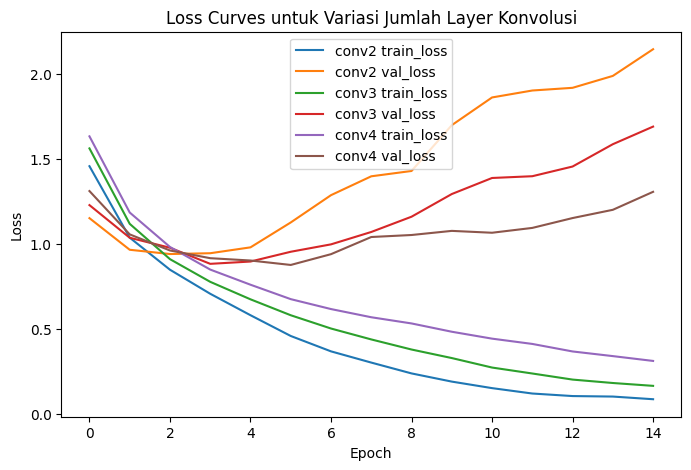

,Macro F1-score
conv4,0.6787
conv3,0.6760
conv2,0.6601


In [30]:
os.makedirs('weights', exist_ok=True)
os.makedirs('models', exist_ok=True)

def build_cnn_model(num_conv_layers, filters_per_layer, kernel_sizes, pooling_type='max'):
    model = Sequential()
    model.add(Input(shape=x_train.shape[1:]))
    for i in range(num_conv_layers):
        model.add(Conv2D(filters=filters_per_layer[i], kernel_size=kernel_sizes[i],
                         activation='relu', padding='same'))
        if pooling_type == 'max':
            model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        else:
            model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dense(250, activation='relu'))
    model.add(Dense(20, activation='softmax'))
    model.compile(
        optimizer=Adam(),
        loss=SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )
    return model

def plot_loss_curves(hist_dict, title):
    plt.figure(figsize=(8,5))
    for name, hist in hist_dict.items():
        plt.plot(hist['loss'], label=f"{name} train_loss")
        plt.plot(hist['val_loss'], label=f"{name} val_loss")
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def show_f1_table(score_dict, title):
    df = pd.DataFrame.from_dict(score_dict, orient='index', columns=["Macro F1-score"])
    df = df.sort_values(by="Macro F1-score", ascending=False)
    display(
        df.style
          .format({"Macro F1-score": "{:.4f}"})
          .set_caption(title)
    )

experiments = [
    {'name':'conv2', 'num_conv_layers':2, 'filters_per_layer':[64,64], 'kernel_sizes':[3,3], 'pooling_type':'max'},
    {'name':'conv3', 'num_conv_layers':3, 'filters_per_layer':[64,64,64], 'kernel_sizes':[3,3,3], 'pooling_type':'max'},
    {'name':'conv4', 'num_conv_layers':4, 'filters_per_layer':[64,64,64,64], 'kernel_sizes':[3,3,3,3], 'pooling_type':'max'},
]

histories = {}
f1_scores = {}

def run_experiments(experiments, epochs=20, batch_size=64):
    results = {}
    for cfg in experiments:
        print(f"--- Eksperimen: {cfg['name']} ---")
        model = build_cnn_model(
          cfg['num_conv_layers'],
          cfg['filters_per_layer'],
          cfg['kernel_sizes'],
          cfg['pooling_type']
        )

        history = model.fit(
            x_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_val, y_val),
            verbose=1
        )
        histories[cfg['name']] = history.history
        y_pred = np.argmax(model.predict(x_test), axis=1)
        y_true = y_test.flatten()
        f1 = f1_score(y_true, y_pred, average='macro')
        f1_scores[cfg['name']] = f1
        print(f"Macro F1-score (test) for {cfg['name']}: {f1:.4f}\n")
    return results


results = run_experiments(experiments, epochs=15, batch_size=64)

plot_loss_curves(histories, 'Loss Curves untuk Variasi Jumlah Layer Konvolusi')
show_f1_table(f1_scores, 'F1-score Akhir untuk Variasi Jumlah Layer Konvolusi')

--- Eksperimen: filter_32-64-128 ---
Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.3400 - loss: 1.7929 - val_accuracy: 0.5815 - val_loss: 1.1536
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6171 - loss: 1.0732 - val_accuracy: 0.6725 - val_loss: 0.9293
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6965 - loss: 0.8557 - val_accuracy: 0.6875 - val_loss: 0.8911
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7491 - loss: 0.7111 - val_accuracy: 0.7024 - val_loss: 0.8818
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7880 - loss: 0.5987 - val_accuracy: 0.7203 - val_loss: 0.8506
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8225 - loss: 0.5037 - val_accuracy: 0.7217 - val_loss: 0.9287
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8534 - loss: 0.4199 - val_accuracy: 0.7055 - val_loss: 1.0126
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8

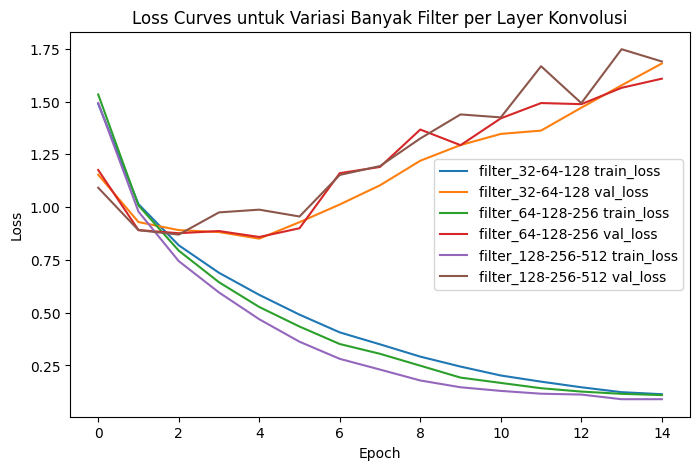

,Macro F1-score
filter_128-256-512,0.7141
filter_64-128-256,0.7138
filter_32-64-128,0.6969


In [31]:
histories = {}
f1_scores = {}
experiments = [
    {'name':'filter_32-64-128','num_conv_layers':3,'filters_per_layer':[32,64,128], 'kernel_sizes':[3,3,3],'pooling_type':'max'},
    {'name':'filter_64-128-256','num_conv_layers':3,'filters_per_layer':[64,128,256], 'kernel_sizes':[3,3,3],'pooling_type':'max'},
    {'name':'filter_128-256-512','num_conv_layers':3,'filters_per_layer':[128,256,512],'kernel_sizes':[3,3,3],'pooling_type':'max'}
]

results = run_experiments(experiments, epochs=15, batch_size=64)
plot_loss_curves(histories, 'Loss Curves untuk Variasi Banyak Filter per Layer Konvolusi')
show_f1_table(f1_scores, 'F1-score Akhir untuk Variasi Banyak Filter per Layer Konvolusi')

--- Eksperimen: kernel_2 ---
Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.3373 - loss: 1.8159 - val_accuracy: 0.5557 - val_loss: 1.2377
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5736 - loss: 1.1906 - val_accuracy: 0.6330 - val_loss: 1.0419
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6489 - loss: 0.9864 - val_accuracy: 0.6650 - val_loss: 0.9472
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6964 - loss: 0.8522 - val_accuracy: 0.6886 - val_loss: 0.8994
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7371 - loss: 0.7371 - val_accuracy: 0.6956 - val_loss: 0.9038
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7707 - loss: 0.6415 - val_accuracy: 0.6947 - val_loss: 0.9450
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7997 - loss: 0.5626 - val_accuracy: 0.7002 - val_loss: 0.9908
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8284 - lo

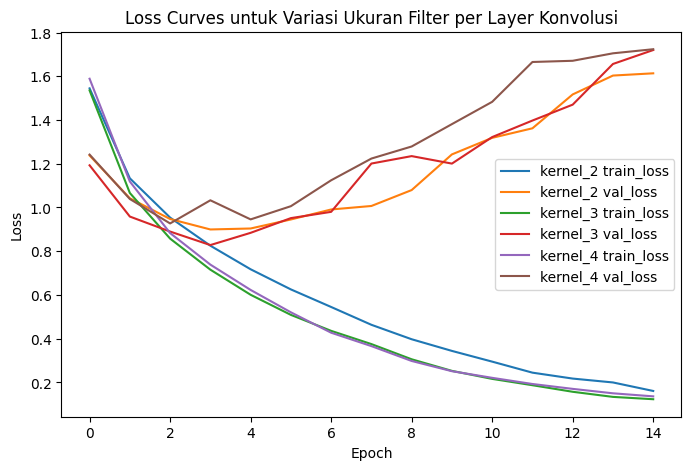

,Macro F1-score
kernel_3,0.6926
kernel_2,0.6817
kernel_4,0.6760


In [32]:
histories = {}
f1_scores = {}
experiments = [
    {'name':'kernel_2','num_conv_layers':3,'filters_per_layer':[32,64,128],'kernel_sizes':[2,2,2],'pooling_type':'max'},
    {'name':'kernel_3','num_conv_layers':3,'filters_per_layer':[32,64,128],'kernel_sizes':[3,3,3],'pooling_type':'max'},
    {'name':'kernel_4','num_conv_layers':3,'filters_per_layer':[32,64,128],'kernel_sizes':[4,4,4],'pooling_type':'max'},
]

results = run_experiments(experiments, epochs=15, batch_size=64)
plot_loss_curves(histories, 'Loss Curves untuk Variasi Ukuran Filter per Layer Konvolusi')
show_f1_table(f1_scores, 'F1-score Akhir untuk Variasi Ukuran Filter per Layer Konvolusi')

--- Eksperimen: pool_max ---
Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.3373 - loss: 1.8166 - val_accuracy: 0.5711 - val_loss: 1.2053
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5944 - loss: 1.1289 - val_accuracy: 0.6441 - val_loss: 1.0040
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6808 - loss: 0.8956 - val_accuracy: 0.6926 - val_loss: 0.8665
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7358 - loss: 0.7506 - val_accuracy: 0.7028 - val_loss: 0.8805
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7800 - loss: 0.6252 - val_accuracy: 0.7133 - val_loss: 0.8877
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8175 - loss: 0.5177 - val_accuracy: 0.6997 - val_loss: 0.9767
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8486 - loss: 0.4322 - val_accuracy: 0.6961 - val_loss: 1.0648
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8703 - lo

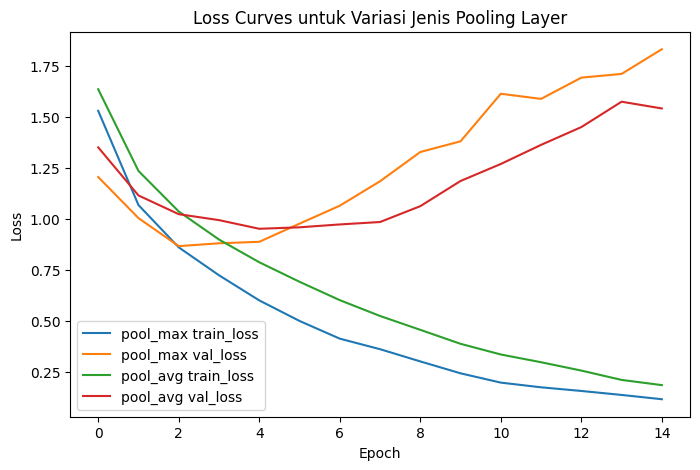

,Macro F1-score
pool_max,0.6927
pool_avg,0.6863


In [33]:
histories = {}
f1_scores = {}
experiments = [
    {'name':'pool_max','num_conv_layers':3,'filters_per_layer':[32,64,128],'kernel_sizes':[3,3,3],'pooling_type':'max'},
    {'name':'pool_avg','num_conv_layers':3,'filters_per_layer':[32,64,128],'kernel_sizes':[3,3,3],'pooling_type':'average'}
]

results = run_experiments(experiments, epochs=15, batch_size=64)
plot_loss_curves(histories, 'Loss Curves untuk Variasi Jenis Pooling Layer')
show_f1_table(f1_scores, 'F1-score Akhir untuk Variasi Jenis Pooling Layer')